In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import networkit as nk
import numpy as np
import matplotlib.pyplot as plt
import time
import phate

from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler

from External.ICT.calculate_ICT import calculate_ICT, compute_widths
from External.clustering import k_means_pp
from External.generation import create_graph
from External.create_k_nearest import is_connected

plt.style.use('standard.mplstyle')

# Hyperparameters
mode = "K_Nearest+Density2"
metric = "euclidean"
position, labels = phate.tree.gen_dla(n_dim=2, n_branch=3,
                                            branch_length=2500, rand_multiplier=2, seed=37, sigma=1)
position = StandardScaler().fit_transform(position)
number_of_nodes = len(position)

In [3]:
# Create the graph
G, position = create_graph(number_of_nodes, mode, position=position, beta=1.25, delta=1)
G.indexEdges()

Final k: 11


In [4]:
weights = []
for u, v, w in G.iterEdgesWeights():
    G.setWeight(u,v,1000*w)
    weights.append(w)
    
is_connected(G)

True

In [5]:
min(weights)

3.1661904825094513e-07

In [6]:
max(weights)

11.148498782789323

In [7]:
# calculate the clusters
ε, δ = 0.03, 0.1
r = 1 / (ε**2) * (int(np.log2(number_of_nodes - 1)) + 1 + np.log(1/δ))
k = int(np.sqrt(r))
k = np.min((k, G.numberOfNodes()))
cluster_centers = k_means_pp(k, position, metric=metric, G=G)

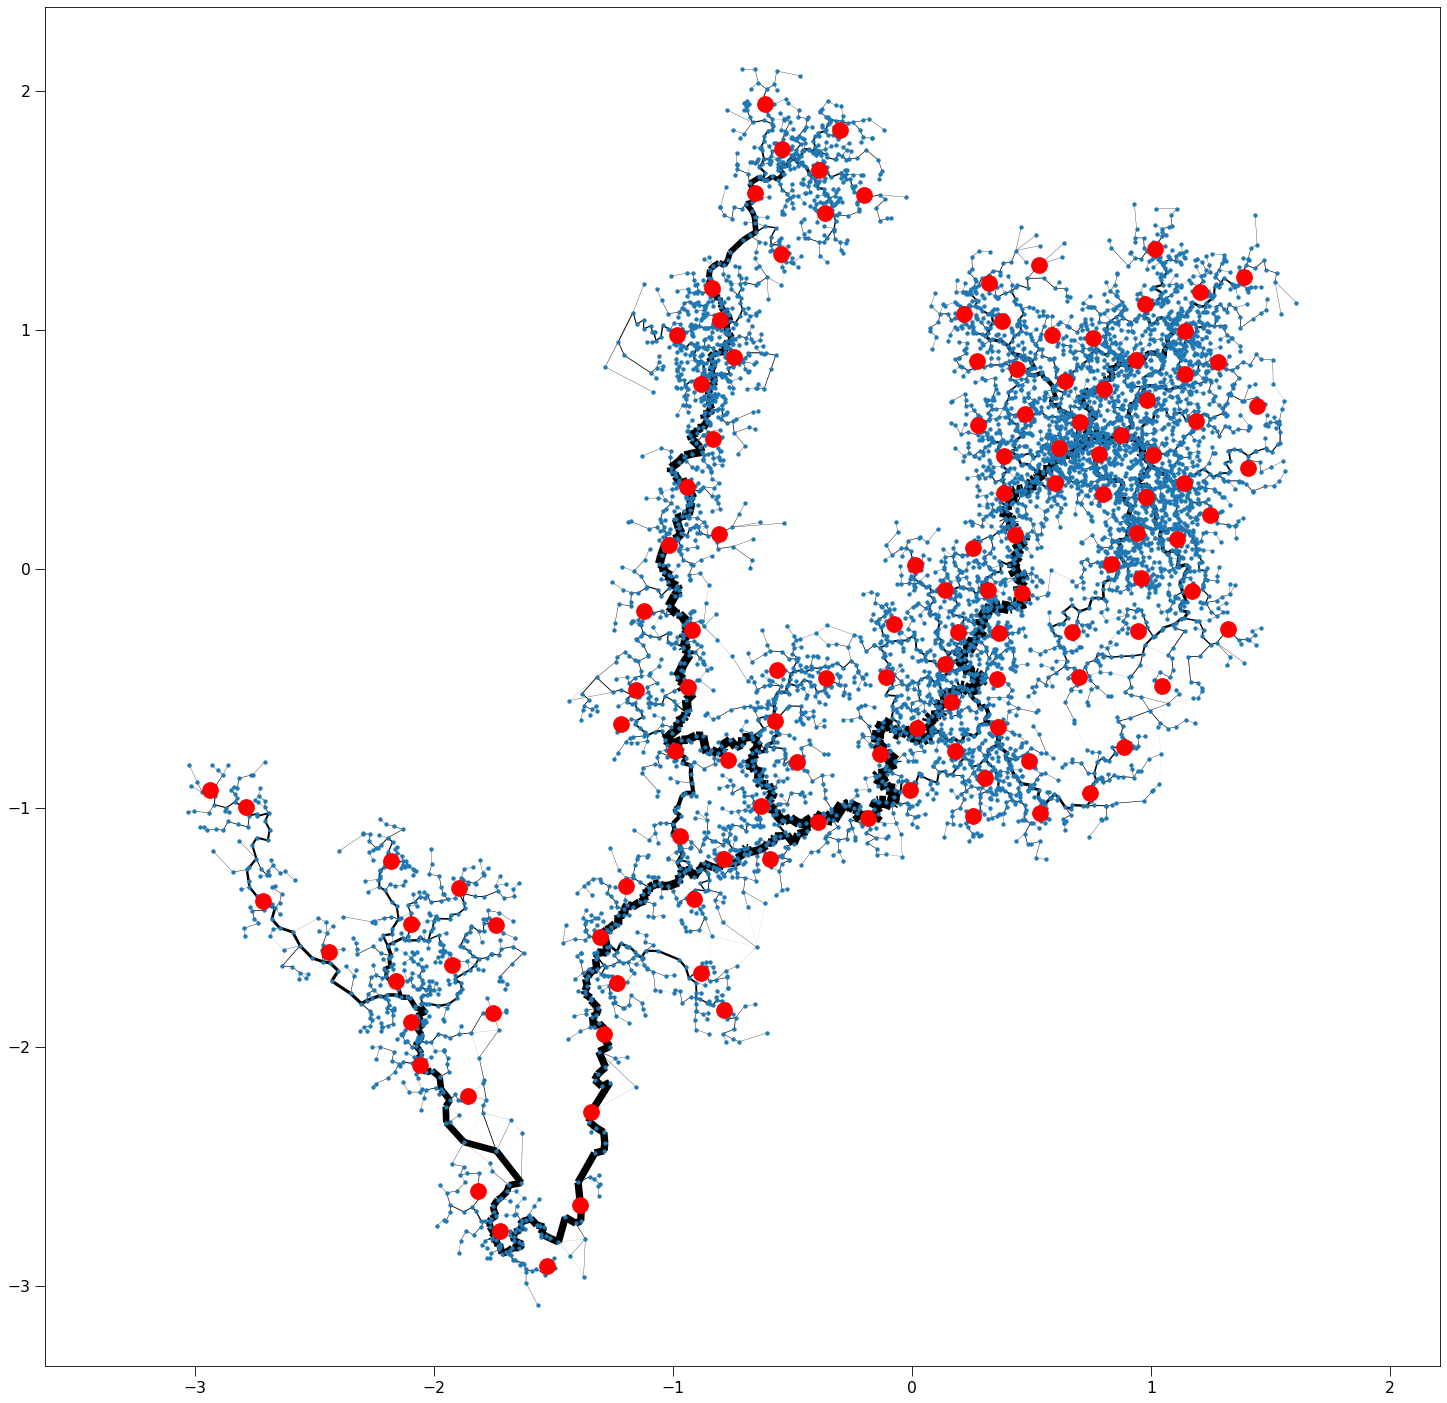

In [8]:
# plot the grahp
fig, ax = plt.subplots(1, figsize=(24,24))
nk.viztasks.drawGraph(G, pos=position, ax=ax, width=compute_widths(G), node_size=10)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax.plot(*position[cluster_centers].T, marker="o", color = "Red")
ax.set_axis_on()
ax.axis("equal")
plt.show()

In [9]:
# calculate the cluster ICT with all aim nodes
start = time.time()
ICT_cluster_all = calculate_ICT(G, algorithm_type="cluster_all", cluster_centers=cluster_centers,
                                zeros_stay_zeros=True, update_G=1.1)
ICT_cluster_all.indexEdges()

# widths of the edges
widths_cluster_all = compute_widths(ICT_cluster_all)
print(time.time()-start)

update Arr 48410 -> 9304
added 758 edges early
update Arr 9304 -> 8458
added 517 edges early
update Arr 8458 -> 7689
added 579 edges early
update Arr 7689 -> 7506
added 152 edges early
update Arr 7506 -> 7502
added 2 edges early
update Arr 7502 -> 7499
added 3 edges early
added 3416 edges early

2907.3617441654205


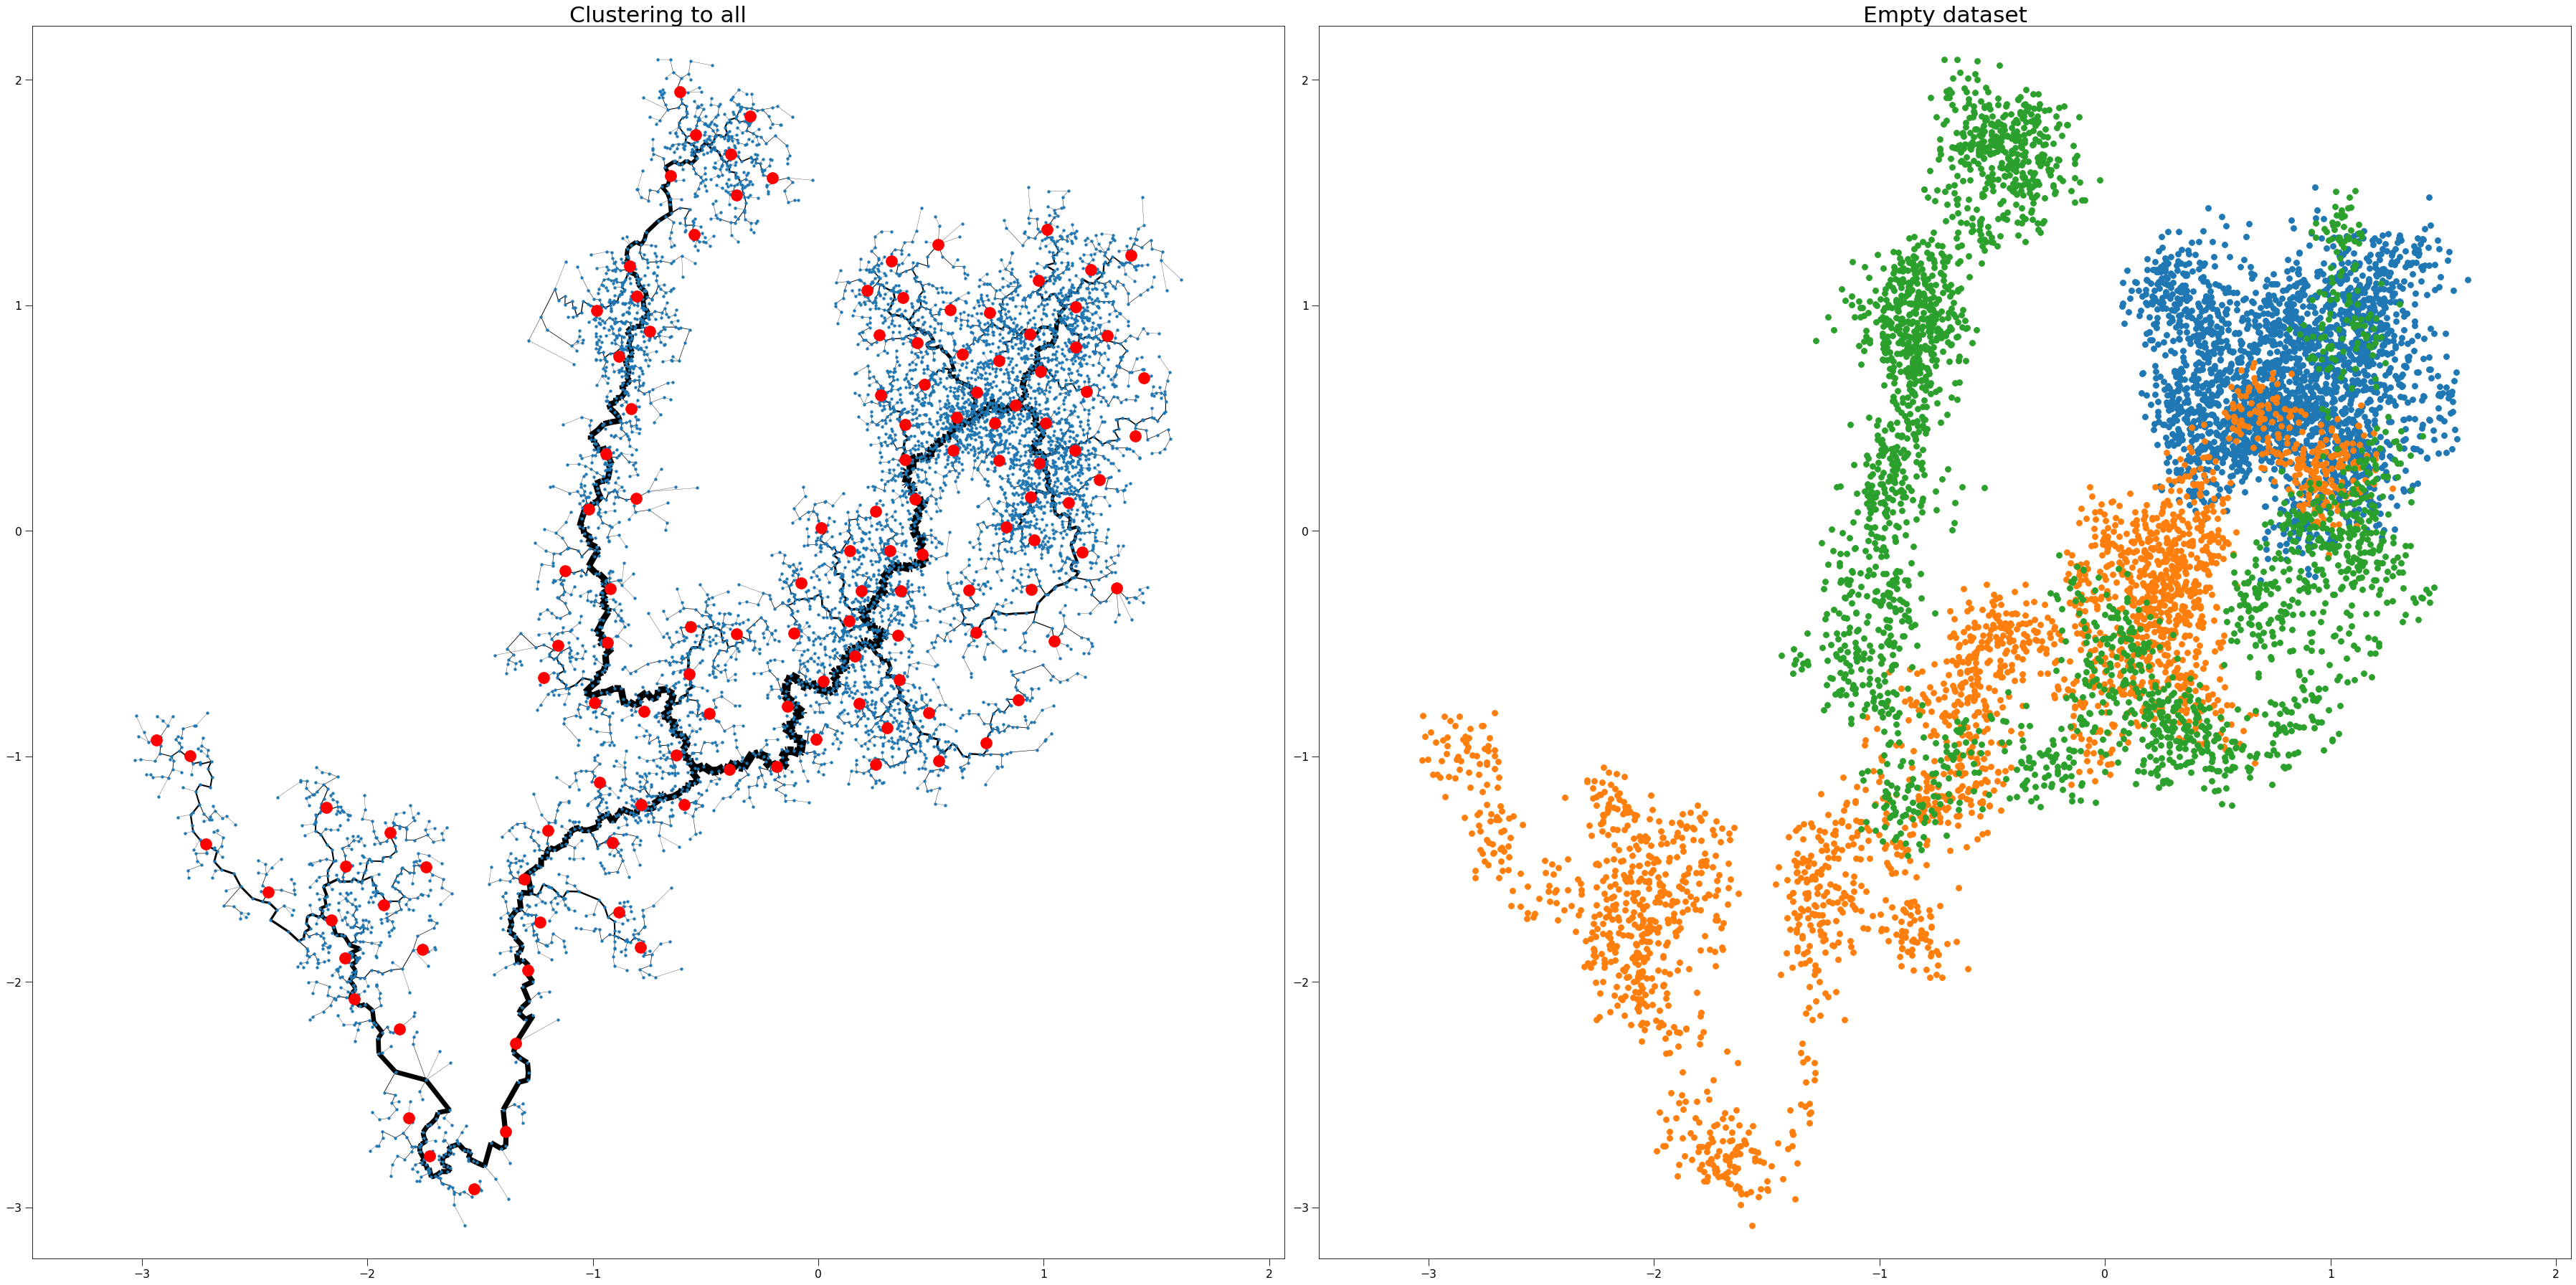

In [11]:
# plotting
graphs = [ICT_cluster_all]
widths = [widths_cluster_all]
names = ["Clustering to all", "Empty dataset"]


number_of_plots = len(names)
fig, ax = plt.subplots(1,2, figsize=(24*2,24))

if number_of_plots == 1:
    ax = [ax]
    
for i in range(number_of_plots):
    if i == 0:
        nk.viztasks.drawGraph(graphs[i], pos=position, ax=ax[i], width=widths[i], node_size=10)
        ax[i].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
        ax[i].plot(*position[cluster_centers].T, marker="o", color = "Red")
        ax[i].set_axis_on()
    else:
        for label in range(len(labels)):
            plt.plot(*position[np.argwhere(labels == label).T[0]].T, label=label)
    ax[i].set_title(names[i])
    ax[i].axis("equal")
    
plt.tight_layout()
plt.savefig("./Output/Images/2D-phate-11-1_25-1.png")
plt.show()